In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix
from collections import Counter

# 경고 메시지 숨기기
warnings.filterwarnings("ignore")


### 데이터 불러오기

In [45]:
df = pd.read_csv("./data/final_data.csv")

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356277 entries, 0 to 356276
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   city                   356277 non-null  int64  
 1   bd                     356277 non-null  int64  
 2   gender                 356277 non-null  int64  
 3   registered_via         356277 non-null  int64  
 4   is_churn               356277 non-null  int64  
 5   payment_plan_sum       356277 non-null  int64  
 6   plan_list_price        356277 non-null  int64  
 7   actual_amount_paid     356277 non-null  int64  
 8   discount_rate          356277 non-null  float64
 9   is_auto_renew          356277 non-null  float64
 10  is_cancel              356277 non-null  float64
 11  transaction_count      356277 non-null  int64  
 12  num_25                 356277 non-null  int64  
 13  num_50                 356277 non-null  int64  
 14  num_75                 356277 non-nu

### train/test 분리

In [47]:
X = df.drop(columns=['is_churn'])
y = df['is_churn']

# train_test_split을 사용하여 데이터를 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 정규화

In [48]:
std_scaler = StandardScaler()
train_scaled = std_scaler.fit_transform(X_train)
test_scaled = std_scaler.transform(X_test)

### 모델 학습

In [49]:
model = lgb.LGBMClassifier()

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],   # 학습률
    'max_depth': [3, 5, 7, 10],                # 트리의 최대 깊이
    'n_estimators': [50, 100, 150]             # 추정기 수
}
skf = StratifiedKFold(n_splits=5)
# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='accuracy')

# 훈련 데이터로 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("Best hyperparameters: ", grid_search.best_params_)

# 최적의 모델로 예측 수행
y_pred = grid_search.best_estimator_.predict(X_test)

# 평가 지표 출력
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 49788, number of negative: 235233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3697
[LightGBM] [Info] Number of data points in the train set: 285021, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174682 -> initscore=-1.552803
[LightGBM] [Info] Start training from score -1.552803
Best hyperparameters:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
Accuracy:  0.8860727517682722
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93     58570
           1       0.73      0.56      0.64     12686

    accuracy                           0.89     71256
   macro avg       0.82      0.76      0.79     71256
weighted avg       0.88      0.

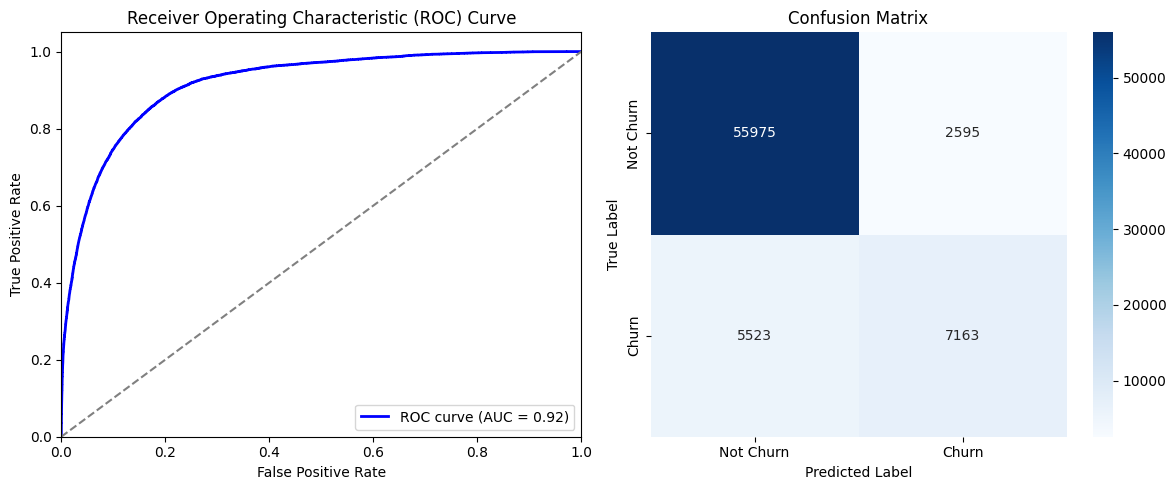

In [50]:

# ROC Curve 및 AUC 계산
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # 클래스 1의 확률값
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve Plot
ax[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선 기준선
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Confusion Matrix Plot
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'], ax=ax[1])
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')
ax[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

### 오버 샘플링

In [51]:
from imblearn.over_sampling import RandomOverSampler

# RandomOverSampler 객체 생성
ros = RandomOverSampler(random_state = 42)

# 오버샘플링 적용
X, y = ros.fit_resample(X, y)

# 클래스 비율 확인
counter = Counter(y)
print(counter)

Counter({0: 293803, 1: 293803})


In [52]:

# train_test_split을 사용하여 데이터를 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:

# LightGBM 모델 정의
model = lgb.LGBMClassifier()

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],   # 학습률
    'max_depth': [3, 5, 7, 10],                # 트리의 최대 깊이
    'n_estimators': [50, 100, 150]             # 추정기 수
}
skf = StratifiedKFold(n_splits=5)
# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='accuracy')

# 훈련 데이터로 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("Best hyperparameters: ", grid_search.best_params_)

# 최적의 모델로 예측 수행
y_pred = grid_search.best_estimator_.predict(X_test)

# 평가 지표 출력
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 234881, number of negative: 235203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3709
[LightGBM] [Info] Number of data points in the train set: 470084, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499658 -> initscore=-0.001370
[LightGBM] [Info] Start training from score -0.001370
Best hyperparameters:  {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150}
Accuracy:  0.8513810180221576
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84     58600
           1       0.83      0.89      0.86     58922

    accuracy                           0.85    117522
   macro avg       0.85      0.85      0.85    117522
weighted avg       0.85      

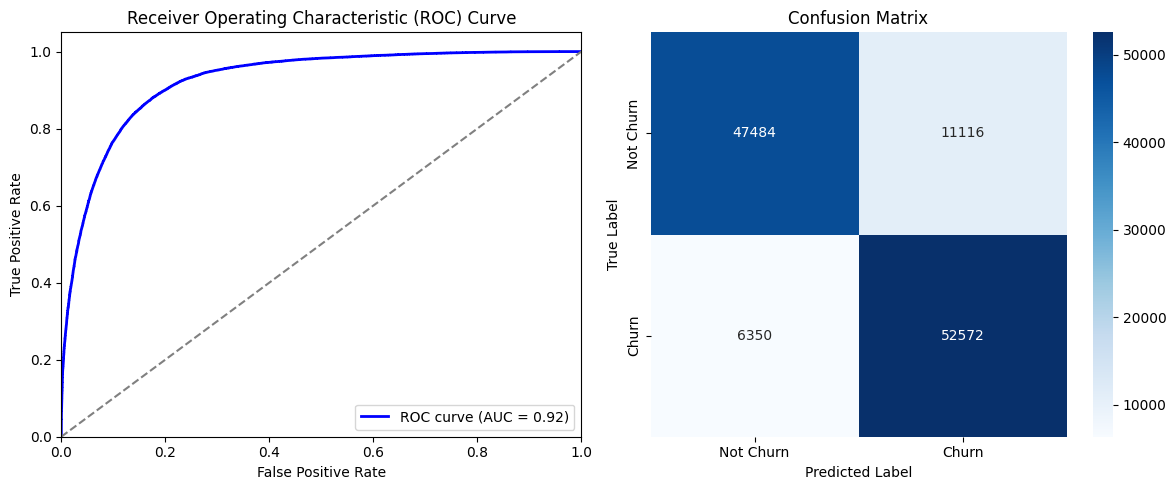

In [54]:

# ROC Curve 및 AUC 계산
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # 클래스 1의 확률값
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve Plot
ax[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선 기준선
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Confusion Matrix Plot
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'], ax=ax[1])
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')
ax[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

### Optuna 하이퍼파라미터 최적화

In [59]:
import optuna
import optuna.visualization as vis

In [ ]:
# 1. 목적 함수 정의
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_error',
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'verbose': -1,  
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    
    # LightGBM 모델 훈련
    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train)
    
    # 예측 및 정확도 평가
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy  # 목적 함수는 최대화하려는 값(여기서는 accuracy)

# 2. Optuna로 최적화 수행
study = optuna.create_study(direction='maximize')  # accuracy를 최대화
study.optimize(objective, n_trials=100)  # 100번의 실험을 통해 최적화 진행

# 3. 최적의 하이퍼파라미터 출력
print('Best hyperparameters:', study.best_params)

[I 2025-02-11 16:28:31,738] A new study created in memory with name: no-name-48189291-d300-43b1-b8d7-930ef7db43fc
[I 2025-02-11 16:28:33,325] Trial 0 finished with value: 0.8459607562839299 and parameters: {'num_leaves': 179, 'max_depth': 10, 'learning_rate': 0.03180944179709, 'n_estimators': 74, 'subsample': 0.8648896588134614, 'colsample_bytree': 0.9032304028036708}. Best is trial 0 with value: 0.8459607562839299.
[I 2025-02-11 16:28:35,875] Trial 1 finished with value: 0.8616939807014857 and parameters: {'num_leaves': 152, 'max_depth': 9, 'learning_rate': 0.07714918388292209, 'n_estimators': 174, 'subsample': 0.9843573225634787, 'colsample_bytree': 0.7794225619535604}. Best is trial 1 with value: 0.8616939807014857.
[I 2025-02-11 16:28:36,660] Trial 2 finished with value: 0.8294446997157979 and parameters: {'num_leaves': 67, 'max_depth': 4, 'learning_rate': 0.022212830069203156, 'n_estimators': 75, 'subsample': 0.5587633123417652, 'colsample_bytree': 0.614010617747518}. Best is tria

Best hyperparameters: {'num_leaves': 300, 'max_depth': 12, 'learning_rate': 0.1963905074701354, 'n_estimators': 200, 'subsample': 0.877696784596948, 'colsample_bytree': 0.6441508167608584}


In [62]:
# 3. 하이퍼파라미터 중요도 시각화
vis.plot_param_importances(study).show()

In [63]:
# 최적화 
vis.plot_optimization_history(study).show()

In [64]:
# 최적의 하이퍼파라미터
best_params = {'num_leaves': 300, 
               'max_depth': 12, 
               'learning_rate': 0.1963905074701354, 
               'n_estimators': 200, 
               'subsample': 0.877696784596948, 
               'colsample_bytree': 0.6441508167608584}

# 최적의 하이퍼파라미터로 모델 정의
model = lgb.LGBMClassifier(**best_params)

# 모델 훈련
model.fit(X_train, y_train)

# 예측 및 정확도 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy:  0.9095233232926601
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91     58600
           1       0.88      0.95      0.91     58922

    accuracy                           0.91    117522
   macro avg       0.91      0.91      0.91    117522
weighted avg       0.91      0.91      0.91    117522



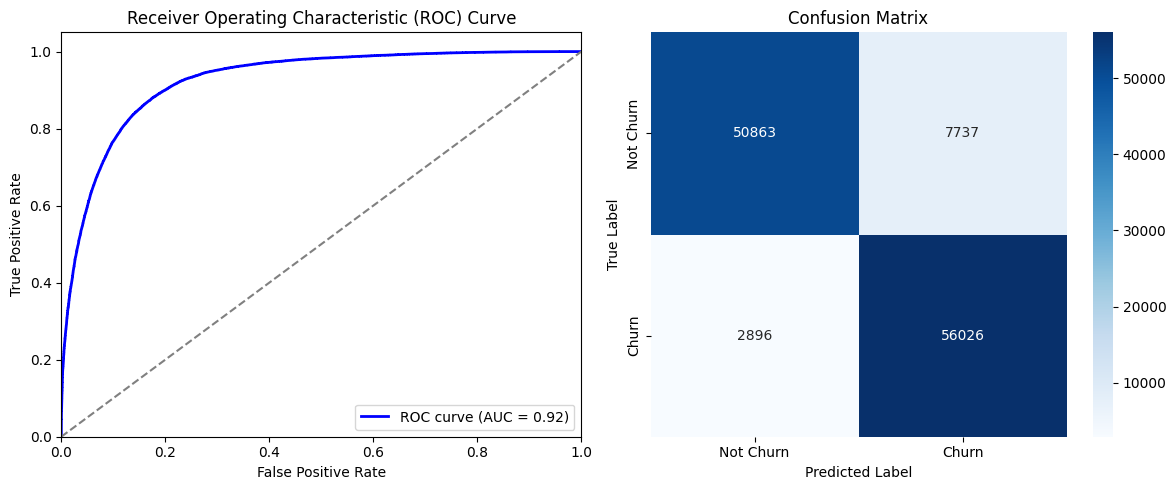

In [65]:

# ROC Curve 및 AUC 계산
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # 클래스 1의 확률값
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 그래프 그리기
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve Plot
ax[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')  # 대각선 기준선
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc="lower right")

# Confusion Matrix Plot
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'], ax=ax[1])
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')
ax[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

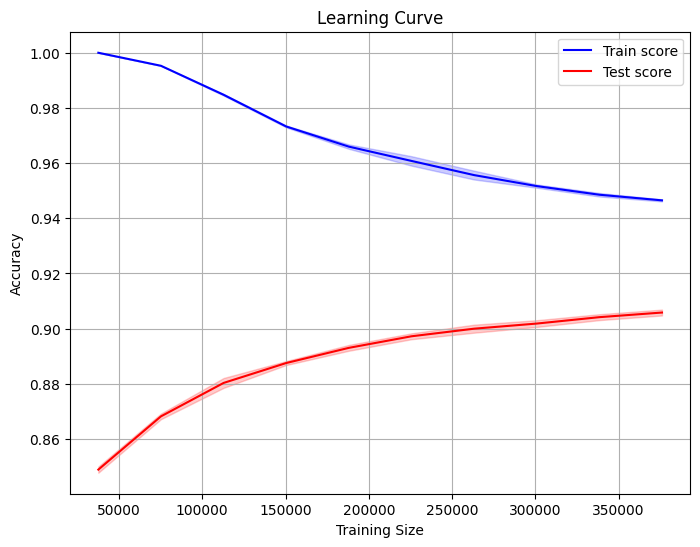

In [68]:

# 모델 정의
model = lgb.LGBMClassifier(**best_params)

# 학습 곡선 데이터 얻기
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10%부터 100%까지 훈련 데이터를 이용
    cv=5,  # 교차 검증
    n_jobs=-1,  # 여러 프로세스를 사용하여 계산을 더 빠르게
    scoring='accuracy'  # 정확도 기반 평가
)

# 평균 및 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Train score", color='blue')
plt.plot(train_sizes, test_mean, label="Test score", color='red')

# 신뢰구간 표시
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.grid(True)
plt.show()